# single differential $CC1p$ cross-section from begining to end

In [1]:
import sys; sys.path.insert(0, '../../'); 
from ccqe_notebook_tools import * 
from mupClassification_notebooks import *
from onbeam_offbeam_notebooks import *
from Xsec_tools import *
%matplotlib inline
sns.set(font_scale=2);sns.set_style("whitegrid");

versions:
{   'OffBeam': 'prod_reco_optfilter_extbnb_v12_mcc8_dev',
    'OnBeam': 'prod_reco_optfilter_bnb_v12_unblind_mcc8',
    'Overlay': 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2',
    'data date': '2018_05_11',
    'date': '2018_05_11',
    'overlay date': '2018_05_11'}
OffBeam_scaling: 0.706302660161 = N(on beam)/N(off beam) before SwT
f(POT): 0.0512441465374 = N(POT on beam)/N(POT MC)


In [2]:
figures_path = '/Users/erezcohen/Desktop/Projects/uBoone/write-ups/Xsec/Figures/1d_differential_Xsec/'

## load mc and data

In [3]:
versions['overlay date'] = '2018_08_16'
versions['Overlay'] = 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2'
versions['data date'] = '2018_08_16'
versions['beam on'] = 'prod_reco_optfilter_bnb_v12_unblind_mcc8'
versions['beam off'] = 'prod_reco_optfilter_extbnb_v12_mcc8_dev'
selected_overlay,selected_overlay_concat,selected_CC1p,genie_CC1p,selected_beam_on,selected_beam_off = load_mc_and_data()

found selected_cosmic.csv, loading it...
checked /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/prod_reco_optfilter_bnb_v12_unblind_mcc8_2018_08_16_selected_on_beam.csv and found the file...
checked /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2_2018_08_16_selected_genie_CC1p.csv and found the file...
8211 selected CC1p events overlay


## 1d cross-section

done looping.
done smearing selected_CC1p
saved  selected_CC1p  to
/Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2_2018_08_16_selected_CC1p.csv
done looping.
done smearing selected_genie_CC1p
saved  selected_genie_CC1p  to
/Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2_2018_08_16_selected_genie_CC1p.csv
done smearing MC generated and selected


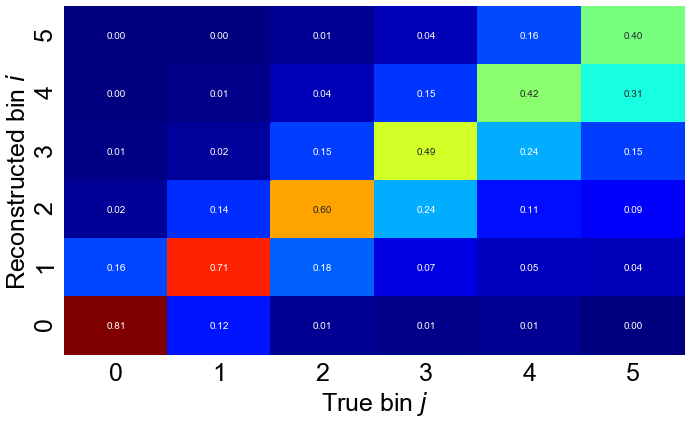

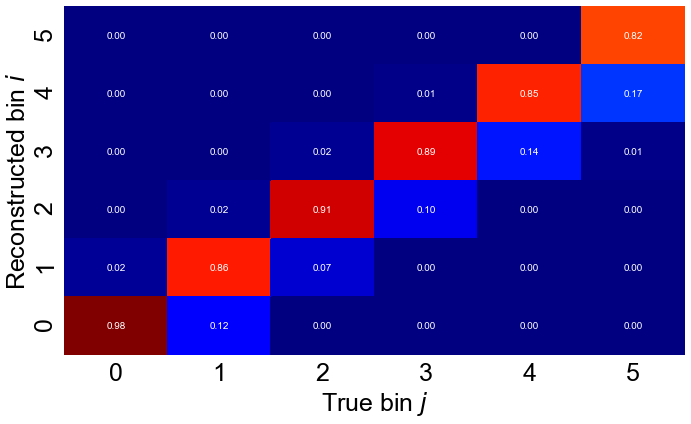

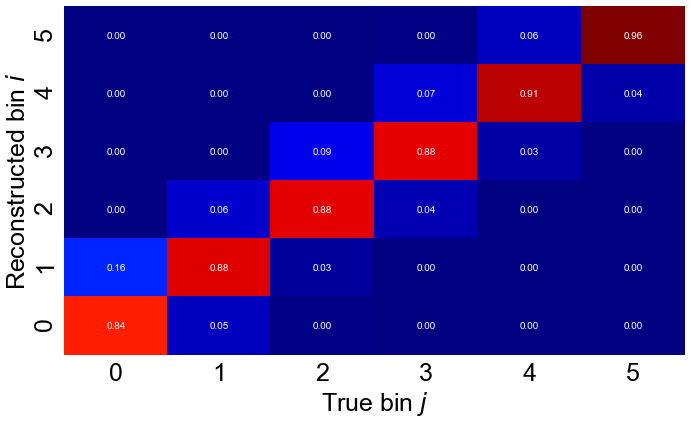

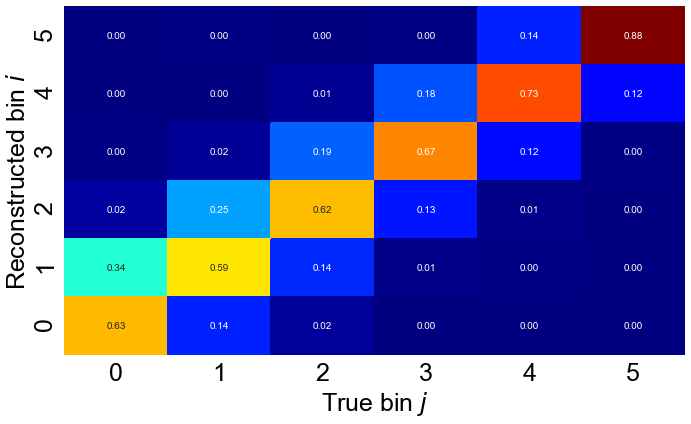

In [4]:
migration_maps = build_migration_maps(selected_CC1p=selected_CC1p)
smear_MC_gen_sel(migration_maps=migration_maps,selected_CC1p=selected_CC1p,genie_CC1p=genie_CC1p)
print 'done smearing MC generated and selected'

In [5]:
prefix = Paths['selected events'] + versions['Overlay'] + '_' + versions['overlay date'] + '_'
print prefix+'selected_genie_CC1p.csv'
genie_CC1p = pd.read_csv(prefix+'selected_genie_CC1p.csv')
selected_CC1p = pd.read_csv(prefix+'selected_CC1p.csv')

/Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2_2018_08_16_selected_genie_CC1p.csv


# Xsec.

In [6]:
def full_chain_Xsec_diff_1d(observable='Pmu',truth_var='truth_Pmu',recovar='reco_Pmu_mcs',smearedvar='',mul=1,ax=None
                            ,mc_scale_factor=1,do_draw_all=False,debug=0):
    bins=Bins[observable]; vlabel=vlabels[observable]; Vlabel=Vlabels[observable]; units=Units[observable]
    xlabel=Vlabel+' ['+units+']' if units is not None else Vlabel

    # (1) background subtraction    
    subtrsact_bkg_1d(selected_beam_off=selected_beam_off,selected_beam_on=selected_beam_on
                     ,selected_overlay_concat=selected_overlay_concat,selected_CC1p=selected_CC1p
                     ,bins=bins,xlabel=xlabel,xvar=recovar,debug=debug,do_draw=do_draw_all)
    
    # (2) efficiency:
    compute_effiency(genie_CC1p=genie_CC1p,selected_CC1p=selected_CC1p
                     ,bins=bins,xvar=smearedvar,xlabel=xlabel,ylabel=r'$\bar{\epsilon}$',do_draw=do_draw_all,mul=mul,debug=debug)    
    
    # (3) cross-section
    Xsec_diff_1d(observable=observable,recovar=recovar,smearedvar=smearedvar,ax=ax,mc_scale_factor=mc_scale_factor,debug=0)

done computing Xsec.
done computing Xsec.
done computing Xsec.
done computing Xsec.


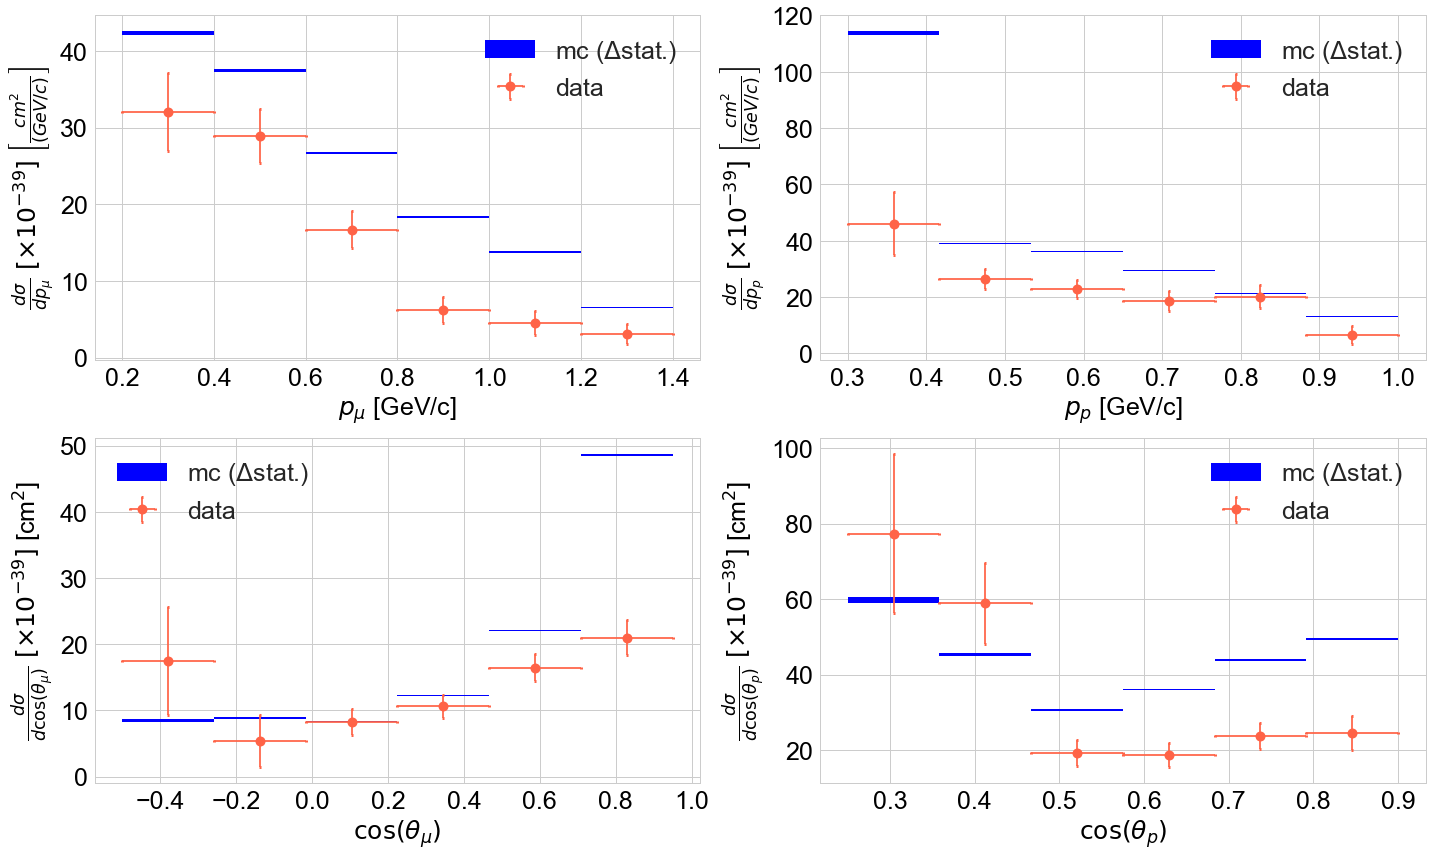

In [7]:
fig=plt.figure(figsize=(20,12))
full_chain_Xsec_diff_1d(observable='Pmu',recovar='reco_Pmu_mcs',smearedvar='smeared_Pmu',ax=fig.add_subplot(2,2,1),do_draw_all=False)
full_chain_Xsec_diff_1d(observable='Pp',recovar='reco_Pp',smearedvar='smeared_Pp',ax=fig.add_subplot(2,2,2),do_draw_all=False)
full_chain_Xsec_diff_1d(observable='cos(theta(mu))',recovar='reco_Pmu_cos_theta',smearedvar='smeared_Pmu_cos_theta',ax=fig.add_subplot(2,2,3),do_draw_all=False)
full_chain_Xsec_diff_1d(observable='cos(theta(p))',recovar='reco_Pp_cos_theta',smearedvar='smeared_Pp_cos_theta',ax=fig.add_subplot(2,2,4),do_draw_all=False)
plt.tight_layout()

done computing Xsec.
done computing Xsec.
done computing Xsec.
done computing Xsec.


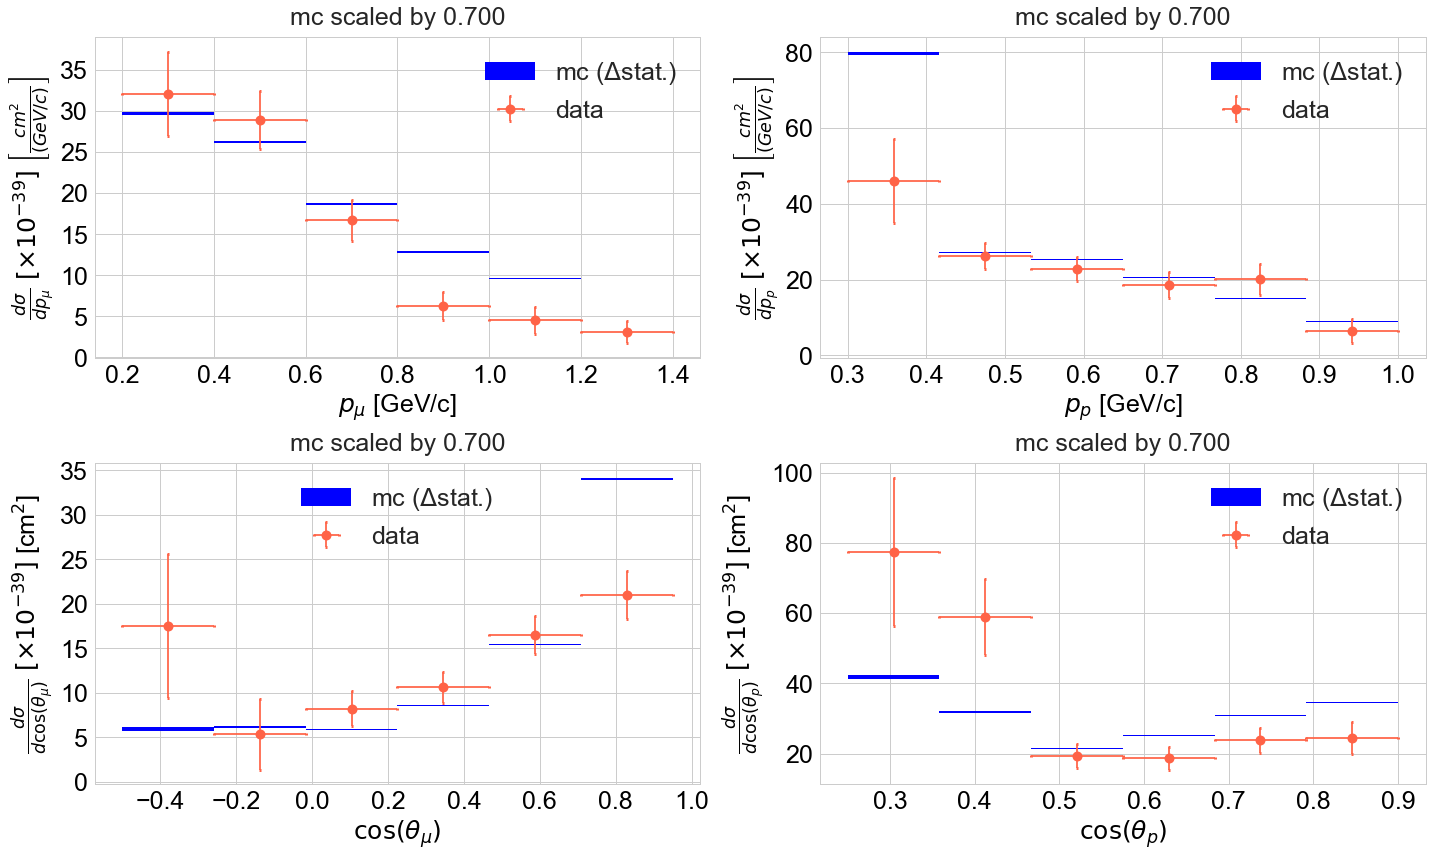

In [9]:
fig=plt.figure(figsize=(20,12))
mc_scale_factor=0.7
full_chain_Xsec_diff_1d(observable='Pmu',recovar='reco_Pmu_mcs',smearedvar='smeared_Pmu',ax=fig.add_subplot(2,2,1),mc_scale_factor=mc_scale_factor)
full_chain_Xsec_diff_1d(observable='Pp',recovar='reco_Pp',smearedvar='smeared_Pp',ax=fig.add_subplot(2,2,2),mc_scale_factor=mc_scale_factor)
full_chain_Xsec_diff_1d(observable='cos(theta(mu))',recovar='reco_Pmu_cos_theta',smearedvar='smeared_Pmu_cos_theta',ax=fig.add_subplot(2,2,3),mc_scale_factor=mc_scale_factor)
full_chain_Xsec_diff_1d(observable='cos(theta(p))',recovar='reco_Pp_cos_theta',smearedvar='smeared_Pp_cos_theta',ax=fig.add_subplot(2,2,4),mc_scale_factor=mc_scale_factor)
plt.tight_layout()